In [ ]:
! git clone https://github.com/Mb-NextTime/early-med.git
! cd early-med && rm -r pycaret && rm -r TabEBM
! cd early-med && git clone https://github.com/Mb-NextTime/pycaret.git && git clone https://github.com/Mb-NextTime/TabEBM.git
! cd early-med && ./setup.sh
! cp early-med/src/utils.py .

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from utils import *

In [2]:
full_data = openml.datasets.get_dataset(40966).get_data()[0]
full_data.shape

(1080, 78)

In [3]:
data, _ = train_test_split(full_data, train_size=200, random_state=0)

In [ ]:
profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 507 to 684
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DYRK1A_N         200 non-null    float64 
 1   ITSN1_N          200 non-null    float64 
 2   BDNF_N           200 non-null    float64 
 3   NR1_N            200 non-null    float64 
 4   NR2A_N           200 non-null    float64 
 5   pAKT_N           200 non-null    float64 
 6   pBRAF_N          200 non-null    float64 
 7   pCAMKII_N        200 non-null    float64 
 8   pCREB_N          200 non-null    float64 
 9   pELK_N           200 non-null    float64 
 10  pERK_N           200 non-null    float64 
 11  pJNK_N           200 non-null    float64 
 12  PKCA_N           200 non-null    float64 
 13  pMEK_N           200 non-null    float64 
 14  pNR1_N           200 non-null    float64 
 15  pNR2A_N          200 non-null    float64 
 16  pNR2B_N          200 non-null    float64 
 17  

In [5]:
n_classes = data['class'].unique().size

---
### CatBoostEncoder

In [6]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [ ]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [8]:
best = exp.create_model('lr')

In [66]:
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import LinearRegression
from skforecast.recursive import ForecasterRecursive

DEFAULT_COLORS = ['deepskyblue', 'limegreen', 'violet', 'sandybrown']
SECONDARY_COLORS = ['lightskyblue', 'lightgreen', 'plum', 'peachpuff']

class LearningCurve:
    def __init__(
        self,
        estimator,
        train_sizes=DEFAULT_TRAIN_SIZES,
        predict_trajectory=True,
        predict_extend_points=5,
        cv=None,
        scoring=None,
        shuffle=False,
        random_state=None,
        **kwargs
    ):
        # Validate the train sizes
        train_sizes = np.asarray(train_sizes)

        # Set the metric parameters to be used later
        self.estimator = estimator
        self.train_sizes = train_sizes
        self.predict_trajectory = predict_trajectory
        self.predict_extend_points = predict_extend_points
        self.cv = cv
        self.scoring = 'balanced_accuracy' if scoring is None else scoring
        self.shuffle = shuffle
        self.random_state = random_state

    def predict_points(self, points, n_points):
        fr = ForecasterRecursive(
            regressor=LinearRegression(),
            lags=4
        )
        fr.fit(pd.Series(points))
        return fr.predict(steps=n_points).to_numpy()

    def fit(self, X, y):
        """
        Fits the learning curve with the wrapped model to the specified data.
        Draws training and test score curves and saves the scores to the
        estimator.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape (n_samples) or (n_samples, n_features)
            Target relative to X for classification.

        Returns
        -------
        self : instance
            Returns the instance of the learning curve visualizer for use in
            pipelines and other sequential transformers.
        """
        # arguments to pass to sk_learning_curve
        sklc_kwargs = {
            key: getattr(self, key)
            for key in (
                "train_sizes",
                "cv",
                "scoring",
                "shuffle",
                "random_state",
            )
        }

        # compute the learning curve and store the scores on the estimator
        curve = sk_learning_curve(self.estimator, X, y, **sklc_kwargs)
        self.train_sizes_, self.train_scores_, self.test_scores_ = curve

        # compute the mean and standard deviation of the training data
        self.train_scores_mean_ = np.mean(self.train_scores_, axis=1)
        self.train_scores_std_ = np.std(self.train_scores_, axis=1)

        # compute the mean and standard deviation of the test data
        self.test_scores_mean_ = np.mean(self.test_scores_, axis=1)
        self.test_scores_std_ = np.std(self.test_scores_, axis=1)

        # draw the curves on the current axes
        self.draw()
        return self

    def draw(self, **kwargs):
        """
        Renders the training and test learning curves.
        """
        self.fig, self.ax = plt.subplots()
        # Specify the curves to draw and their labels
        labels = ("Training Score", "Cross Validation Score")
        curves = (
            (self.train_scores_mean_, self.train_scores_std_),
            (self.test_scores_mean_, self.test_scores_std_),
        )

        # Get the colors for the train and test curves
        colors = DEFAULT_COLORS[:2]

        # Plot the fill betweens first so they are behind the curves.
        for idx, (mean, std) in enumerate(curves):
            # Plot one standard deviation above and below the mean
            self.ax.fill_between(
                self.train_sizes_, mean - std, mean + std, alpha=0.25, color=colors[idx]
            )

        # Plot the mean curves so they are in front of the variance fill
        for idx, (mean, _) in enumerate(curves):
            self.ax.plot(
                self.train_sizes_, mean, "o-", color=colors[idx], label=labels[idx]
            )

        if self.predict_trajectory:
            self.extend_train_sizes_ = self.predict_points(self.train_sizes_, self.predict_extend_points)
            self.extend_train_sizes_ = np.concatenate(([self.train_sizes_[-1]], self.extend_train_sizes_))

            predict_colors = SECONDARY_COLORS[:2]

            extended_curves = []
            for curve in curves:
                extended_curve_stats = []
                for stats in curve:
                    extended_stats = self.predict_points(stats, self.predict_extend_points)
                    extended_curve_stats.append(
                        np.concatenate(([stats[-1]], extended_stats))
                    )
                extended_curves.append(extended_curve_stats)


            # Plot the fill betweens first so they are behind the curves.
            for idx, (mean, std) in enumerate(extended_curves):
                # Plot one standard deviation above and below the mean
                self.ax.fill_between(
                    self.extend_train_sizes_, mean - std, mean + std, alpha=0.25, color=predict_colors[idx]
                )

            for idx, (mean, _) in enumerate(extended_curves):
                self.ax.plot(
                    self.extend_train_sizes_, mean, "o--",
                    color=predict_colors[idx], label='Expected '+labels[idx]
                )

        self.finalize()

        return self.ax

    def finalize(self, **kwargs):
        """
        Add the title, legend, and other visual final touches to the plot.
        """
        # Set the title of the figure
        self.ax.set_title("Learning Curve")

        # Add the legend
        self.ax.legend(frameon=True, loc="best")

        # Set the axis labels
        self.ax.set_xlabel("Training Instances")
        self.ax.set_ylabel("Score")

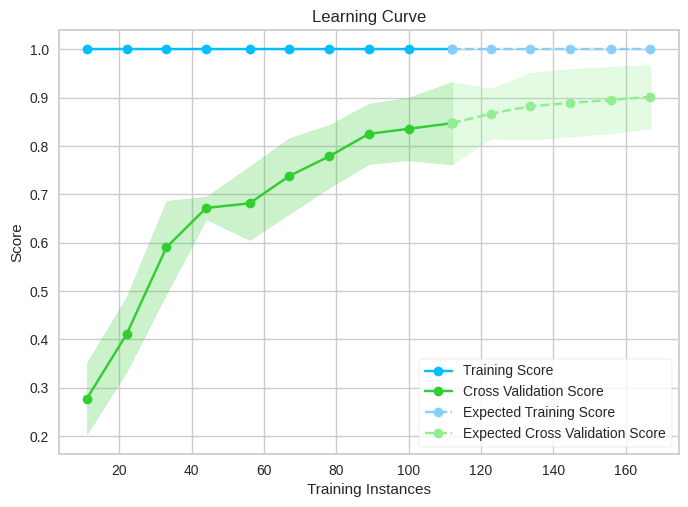

In [70]:
lc = LearningCurve(best, predict_extend_points=5)
lc.fit(exp.X_train_transformed, exp.y_train_transformed)

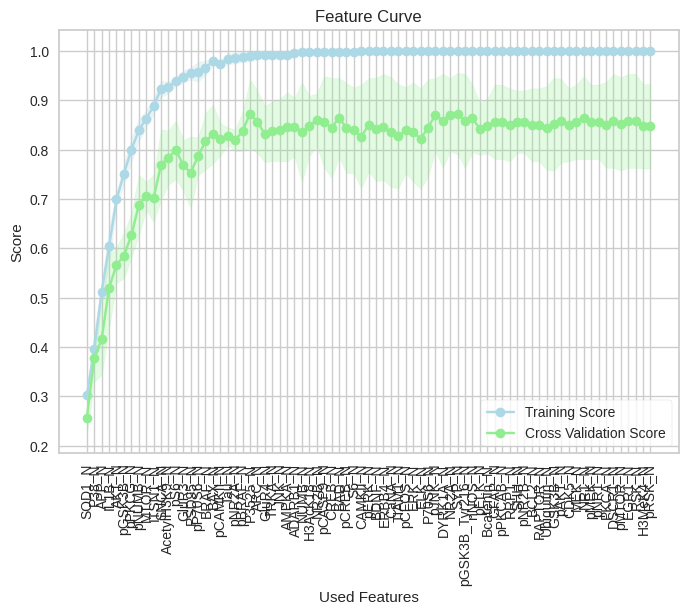

In [23]:
fc = FeatureCurve(best)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

In [25]:
fc.features_order[:20]

Index(['SOD1_N', 'P38_N', 'APP_N', 'IL1B_N', 'AKT_N', 'pGSK3B_N', 'pPKCG_N',
       'pNUMB_N', 'MTOR_N', 'ITSN1_N', 'SNCA_N', 'AcetylH3K9_N', 'pS6_N',
       'GluR3_N', 'PSD95_N', 'pP70S6_N', 'BRAF_N', 'BAX_N', 'pCAMKII_N',
       'Tau_N'],
      dtype='object')

CPU times: user 24.8 s, sys: 55.8 ms, total: 24.8 s
Wall time: 24.8 s


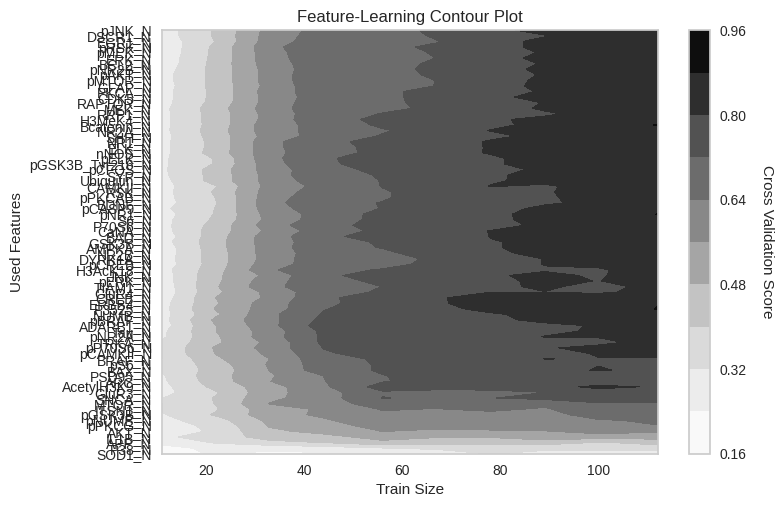

In [38]:
%%time
flp = FeatureLearningPlot(best)
flp.fit(exp.X_train_transformed, exp.y_train_transformed)

---
### TabEBM with CatBoostEncoder

In [12]:
from tabebm.TabEBM import TabEBM

In [13]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.11/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_42.cpkt
It has about 100MB, so this might take a moment.


In [14]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [15]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.7470734126984127

In [16]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.8206845238095237

---
### Full data experiement

In [ ]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [ ]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [ ]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data[[*fc.features_order_[:20], 'class']],
    target='class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [ ]:
fc.features_order_[:20]

Index(['SOD1_N', 'P38_N', 'APP_N', 'IL1B_N', 'AKT_N', 'pPKCG_N', 'pGSK3B_N',
       'pNUMB_N', 'MTOR_N', 'ITSN1_N', 'SNCA_N', 'AcetylH3K9_N', 'GluR3_N',
       'PSD95_N', 'pCAMKII_N', 'pS6_N', 'BAX_N', 'BRAF_N', 'ARC_N',
       'pP70S6_N'],
      dtype='object')

In [ ]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)